In [1]:
# Import dataset and dataloader
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torch
import pandas as pd
from collections import namedtuple

n_class = 27

# a label and all meta information
Label = namedtuple( 'Label' , [
    'name'        , 
    'level3Id'    , 
    'color'       , 
    ] )

labels = [
    #       name                     level3Id  color
    Label(  'road'                 ,    0  , (128, 64,128)  ),
    Label(  'drivable fallback'    ,    1  , ( 81,  0, 81)  ),
    Label(  'sidewalk'             ,    2  , (244, 35,232)  ),
    Label(  'non-drivable fallback',    3  , (152,251,152)  ),
    Label(  'person/animal'        ,    4  , (220, 20, 60)  ),
    Label(  'rider'                ,    5  , (255,  0,  0)  ),
    Label(  'motorcycle'           ,    6  , (  0,  0,230)  ),
    Label(  'bicycle'              ,   7  , (119, 11, 32)  ),
    Label(  'autorickshaw'         ,   8  , (255, 204, 54) ),
    Label(  'car'                  ,   9  , (  0,  0,142)  ),
    Label(  'truck'                ,  10 ,  (  0,  0, 70)  ),
    Label(  'bus'                  ,  11 ,  (  0, 60,100)  ),
    Label(  'vehicle fallback'     ,  12 ,  (136, 143, 153)),  
    Label(  'curb'                 ,   13 ,  (220, 190, 40)),
    Label(  'wall'                 ,  14 ,  (102,102,156)  ),
    Label(  'fence'                ,  15 ,  (190,153,153)  ),
    Label(  'guard rail'           ,  16 ,  (180,165,180)  ),
    Label(  'billboard'            ,   17 ,  (174, 64, 67) ),
    Label(  'traffic sign'         ,  18 ,  (220,220,  0)  ),
    Label(  'traffic light'        ,  19 ,  (250,170, 30)  ),
    Label(  'pole'                 ,  20 ,  (153,153,153)  ),
    Label(  'obs-str-bar-fallback' , 21 ,  (169, 187, 214) ),  
    Label(  'building'             ,  22 ,  ( 70, 70, 70)  ),
    Label(  'bridge/tunnel'        ,  23 ,  (150,100,100)  ),
    Label(  'vegetation'           ,  24 ,  (107,142, 35)  ),
    Label(  'sky'                  ,  25 ,  ( 70,130,180)  ),
    Label(  'unlabeled'            ,  26 ,  (  0,  0,  0)  ),
]   

class IddDataset(Dataset):

    def __init__(self, csv_file, n_class=n_class, transforms_=None):
        self.data      = pd.read_csv(csv_file)
        self.n_class   = n_class
        self.mode = csv_file
        
        # Add any transformations here
        self.resize_transform = transforms.Resize((256, 256))
        # The following transformation normalizes each channel using the mean and std provided
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img = Image.open(img_name).convert('RGB')
        label_name = self.data.iloc[idx, 1]
        label = Image.open(label_name)
        #print("Img type is {}".format(type(img)))
        img = self.resize_transform(img)
        
        label = self.resize_transform(label)
        
        img = np.asarray(img) / 255. # scaling [0-255] values to [0-1]
        label = np.asarray(label)
        # Normalization
        img = self.transforms(img).float()
        # Convert to tensor
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.shape
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1
        
        return img, target, label

In [2]:
train_dataset = IddDataset(csv_file='train.csv')
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')


train_loader = DataLoader(dataset=train_dataset, batch_size= 32, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 32, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 32, num_workers=4, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'> torch.Size([3, 256, 256])


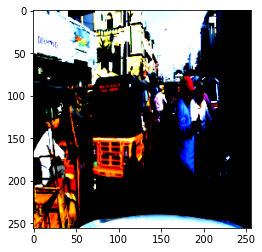

In [3]:
import matplotlib.pyplot as plt

train_image = train_dataset.__getitem__(0)
print(type(train_image[0]),train_image[0].shape)
tensor_image = train_image[0]
plt.imshow(tensor_image.permute(1, 2, 0))

In [4]:
import torch.nn as nn

# dice_coefficient_loss() is used to compute the Dice Coefficient loss function
class dice_coefficient_loss(nn.Module):
    def __init__(self):
        """
            Initialize the constructor for this class
        """
        super(dice_coefficient_loss, self).__init__()
    
    def forward(self, pred, target):
        axes = tuple(range(2, len(pred.shape)))
        numerator = 2 * torch.sum(pred * target, axes)
        denominator = torch.sum((pred * pred) + (target * target), axes)
        return 1 - torch.mean((numerator + 1e-6) / (denominator + 1e-6))

In [5]:
from torchvision import utils
from newModel import *
from utils_new import *
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import time
import pandas as pd 
from collections import defaultdict

# First read the dataset
train_dataset = IddDataset(csv_file='train.csv')
val_dataset = IddDataset(csv_file='val.csv')
test_dataset = IddDataset(csv_file='test.csv')

train_loader = DataLoader(dataset=train_dataset, batch_size= 32, num_workers=4, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size= 32, num_workers=4, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size= 32, num_workers=4, shuffle=False)

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)
        
epochs = 100
n_class = 27
criterion = dice_coefficient_loss()
resNet_model = resNet(n_class=n_class)
print("No of classes = ",n_class)
learning_rate = 0.005
optimizer = optim.Adam(resNet_model.parameters(), lr=learning_rate)
resNet_model.apply(init_weights)

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using GPU")
    resNet_model = resNet_model.cuda()

def train(learning_rate):
    """
        train() - This function is used to complete training including early stopping
    """
    print("Reached train function")
    continuous_epochs, best_loss = 0, float('inf')
    val_loss = []
    train_loss = []
    for epoch in range(epochs):
        train_loss_batch = []
        ts = time.time()
        print("Epoch: {}".format(epoch))
        for itera, (X, tar, Y) in enumerate(train_loader):
            optimizer.zero_grad()
            if use_gpu:
                inputs = X.cuda()
                train_labels = Y.cuda()
                train_targets = tar.cuda()
            else:
                inputs, train_labels, train_targets = X, Y, tar

            outputs = resNet_model(inputs)
            loss = criterion(outputs, train_targets)
            loss = torch.unsqueeze(loss, 0)
            loss = loss.mean()
            train_loss_batch.append(loss.item())
            loss.backward()
            optimizer.step()
            
            if itera % 100 == 0:
                print("TRAINING: epoch{}, iter{}, loss: {}".format(epoch, itera, loss.item()))
        torch.cuda.empty_cache()
        print("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
        train_loss.append(np.mean(np.array(train_loss_batch)))
        curr_val_loss = val(epoch)
        val_loss.append(curr_val_loss)
        if curr_val_loss < best_loss:
            best_loss = curr_val_loss
            model_name = 'resNet_model_best_model_' + str(learning_rate) + '_' + str(epochs) + "_modifiedEarlyStop"
            torch.save(resNet_model, model_name)
            continuous_epochs = 0
        else:
            continuous_epochs += 1
            if(continuous_epochs == 5):
                print("Earlystop after {} epochs".format(epoch))
                return train_loss, val_loss
        torch.save(resNet_model, 'resNet_last_saved_model_modifiedEarlyStop')
        resNet_model.train()
    return train_loss, val_loss

No of classes =  27
Using GPU


In [6]:
def val(epoch):
    """
        Runs inference of the best model on the validation set
    """
    resNet_model.eval()
    val_loss = []
    val_iou = []
    val_acc = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            if use_gpu:
                inputs = X.cuda()
                val_labels = Y.cuda()
                val_targets = tar.cuda()
            else:
                inputs, val_labels = X, Y
            
            outputs = resNet_model(inputs)
            loss = criterion(outputs, val_targets)
            loss = torch.unsqueeze(loss, 0)
            loss = loss.mean()
            # Appending this value to the validation loss
            val_loss.append(loss.item())
            if itera % 100 == 0:
                print("VALIDATION: iter{}, loss: {}".format(itera, loss.item()))
            
            predictions = F.softmax(outputs, 1)
            predictions = torch.argmax(predictions, dim=1)
            iou_row, avg_iou, pix_acc = iou(predictions, val_labels, True)
            val_iou.append(avg_iou)
            val_acc.append(pix_acc)
        
        avg_loss = np.mean(np.asarray(val_loss))
        avg_iou = np.mean(np.asarray(val_iou))
        avg_acc = np.mean(np.asarray(val_acc))
        print("Validation epoch {}: avg_iou = {}, avg_acc = {}".format(epoch,avg_iou,avg_acc))
    
    return avg_loss

In [7]:
def test(learning_rate, epochs):
    model_name = 'resNet_model_best_model_' + str(learning_rate) + '_' + str(epochs) + "_modifiedEarlyStop"
    resNet_model = torch.load(model_name)
    resNet_model.eval()
    
    # Make sure to include a softmax after the output from your model
    test_iou = []
    test_acc = []
    test_ious_cls = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                test_labels = Y.cuda()# Move your labels onto the gpu
            else:
                inputs, test_labels = X, Y
            outputs = resNet_model(inputs)
            predictions = F.softmax(outputs, 1)
            # Create one-hot encoding
            predictions = torch.argmax(predictions, dim = 1)
            iou_row, avg_iou, pix_acc = iou(predictions, test_labels)
            # iou_row shouldn't be None
            if iou_row is not None:
                test_ious_cls.append(iou_row)
            # IoU and accuracy values have been computed here
            test_iou.append(avg_iou)
            test_acc.append(pix_acc)
        
        # Here, I have computed both the mean and accuracy values
        avg_iou = np.mean(np.asarray(test_iou))
        avg_acc = np.mean(np.asarray(pix_acc))
        if iou_row is not None:
            avg_ious_cls = np.nanmean(np.asarray(test_ious_cls), axis=0)
        print("Final test from best model : avg_iou = {}, avg_acc = {}".format(avg_iou,avg_acc))
        print(" Class wise ious getting saved in resNet_IOU_Classwise.csv file")
        
        if iou_row is not None:
            d = []
            labels_len = len(labels)
            for idx in range(0, labels_len - 1):
                d.append((labels[idx].name, avg_ious_cls[labels[idx].level3Id]))
                df = pd.DataFrame(d, columns=('Label name', 'IoU'))
                df.to_csv('resNet_IOU_Classwise_modifiedEarlyStop.csv', sep='\t')
        
            test_loader = DataLoader(dataset=test_dataset, batch_size= 32, num_workers=4, shuffle=False)
            for itera, (X, tar, Y) in enumerate(test_loader):
                if use_gpu:
                    inputs = X.cuda()# Move your inputs onto the gpu
                    test_labels = tar.cuda()# Move your labels onto the gpu
                else:
                    inputs, test_labels = X, tar#.long() # Unpack variables into inputs and labels
                outputs = resNet_model(inputs)
                predictions = F.softmax(outputs, 1)
                predictions = torch.argmax(predictions,dim=1)
                break
            predictions = predictions.cpu().numpy()
            inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
            plt.imshow(inputImage, cmap='gray')
            plt.show()
            rows, cols = predictions.shape[1], predictions.shape[2]

            # Print the labels array here
            new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
            # Rearranging the image here
            for row in range(rows):
                for col in range(cols):
                    idx = int(predictions[0][row][col])
                    new_predictions[row][col][:] = np.asarray(labels[idx].color)/255       

            # Print and display overlaying grayscale and semantically segmented image
            plt.imshow(inputImage, cmap='gray')
            plt.imshow(new_predictions, cmap='jet', alpha=0.5)
            fig_name = "Overlayed_resNet_modifiedEarlyStop" + str(learning_rate) + '_' + str(epochs) + ".jpg"  
            plt.savefig(fig_name)
            plt.show()

In [8]:
def plot_loss_curves(train_loss,val_loss, learning_rate=10**-3):
    title = "Loss curves at learning rate = " + str(learning_rate)
    fig_name = "Loss_resNet_modifiedEarlyStopping.jpg"
    x = [i for i in range(len(train_loss))]
    plt.plot(x, train_loss,label="Train Loss")
    plt.plot(x, val_loss,label="Validation Loss")
    plt.legend()
    plt.xlabel("# of epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.title(title)
    plt.savefig(fig_name)
    plt.show()

In [9]:
min_power, max_power = int(-3), int(-2)
learning_rates = [5*10**i for i in range(min_power, max_power)]

# Based on these values of learning rates, we could compute the training and validation losses
best_learning_rate, best_val_loss = 10, float('inf')
for lr in learning_rates:
    train_loss, val_loss = train(lr)
    curr_val_loss = np.min(np.asarray(val_loss))
    if(curr_val_loss < best_val_loss):
        best_val_loss = curr_val_loss
        best_learning_rate = lr
    plot_loss_curves(train_loss,val_loss, lr)
    print("At learning rate of {}, train and val loss are {} and {}".format(lr, train_loss, val_loss))
print("Best learning rate for the model = {}".format(best_learning_rate))

print("Starting the process on the test set")
test(best_learning_rate, epochs)

Reached train function
Epoch: 0
TRAINING: epoch0, iter0, loss: 0.9995806813240051


KeyboardInterrupt: 

Final test from best model : avg_iou = 0.6378106484337459, avg_acc = 0.7452518939971924
 Class wise ious getting saved in resNet_IOU_Classwise.csv file


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


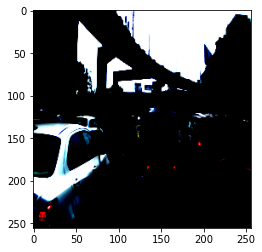

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


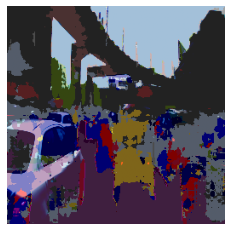

In [11]:
def test(learning_rate, epochs):
    model_name = 'resNet_model_best_model_' + str(learning_rate) + '_' + str(epochs)
    resNet_model = torch.load(model_name)
    resNet_model.eval()
    
    # Make sure to include a softmax after the output from your model
    test_iou = []
    test_acc = []
    test_ious_cls = []
    with torch.no_grad():
        for itera, (X, tar, Y) in enumerate(val_loader):
            if use_gpu:
                inputs = X.cuda()# Move your inputs onto the gpu
                test_labels = Y.cuda()# Move your labels onto the gpu
            else:
                inputs, test_labels = X, Y
            outputs = resNet_model(inputs)
            predictions = F.softmax(outputs, 1)
            # Create one-hot encoding
            predictions = torch.argmax(predictions, dim = 1)
            iou_row, avg_iou, pix_acc = iou(predictions, test_labels)
            # iou_row shouldn't be None
            if iou_row is not None:
                test_ious_cls.append(iou_row)
            # IoU and accuracy values have been computed here
            test_iou.append(avg_iou)
            test_acc.append(pix_acc)
        
        # Here, I have computed both the mean and accuracy values
        avg_iou = np.mean(np.asarray(test_iou))
        avg_acc = np.mean(np.asarray(pix_acc))
        if iou_row is not None:
            avg_ious_cls = np.nanmean(np.asarray(test_ious_cls), axis=0)
        print("Final test from best model : avg_iou = {}, avg_acc = {}".format(avg_iou,avg_acc))
        print(" Class wise ious getting saved in resNet_IOU_Classwise.csv file")
        
        if iou_row is not None:
            d = []
            labels_len = len(labels)
            for idx in range(0, labels_len - 1):
                d.append((labels[idx].name, avg_ious_cls[labels[idx].level3Id]))
                df = pd.DataFrame(d, columns=('Label name', 'IoU'))
                df.to_csv('resNet_IOU_Classwise.csv', sep='\t')
        
            test_loader = DataLoader(dataset=test_dataset, batch_size= 1, num_workers=4, shuffle=False)
            for itera, (X, tar, Y) in enumerate(test_loader):
                if use_gpu:
                    inputs = X.cuda()# Move your inputs onto the gpu
                    test_labels = tar.cuda()# Move your labels onto the gpu
                else:
                    inputs, test_labels = X, tar#.long() # Unpack variables into inputs and labels
                outputs = resNet_model(inputs)
                predictions = F.softmax(outputs, 1)
                predictions = torch.argmax(predictions,dim=1)
                break
            predictions = predictions.cpu().numpy()
            inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
            plt.imshow(inputImage, cmap='gray')
            plt.show()
            rows, cols = predictions.shape[1], predictions.shape[2]

            # Print the labels array here
            new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
            # Rearranging the image here
            for row in range(rows):
                for col in range(cols):
                    idx = int(predictions[0][row][col])
                    new_predictions[row][col][:] = np.asarray(labels[idx].color)/255  

            # Print and display overlaying grayscale and semantically segmented image
            plt.imshow(inputImage, cmap='gray')
            plt.imshow(new_predictions, alpha=0.5)
            plt.axis('off')
            fig_name = "Overlayed_resNet" + str(learning_rate) + '_' + str(epochs) + ".jpg"  
            plt.savefig(fig_name)
            plt.show()
            
test(0.005, 100)

In [13]:
# Import dataset and dataloader
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from PIL import Image
import torch
import pandas as pd
from collections import namedtuple

n_class = 27

# a label and all meta information
Label = namedtuple( 'Label' , [
    'name'        , 
    'level3Id'    , 
    'color'       , 
    ] )

labels = [
    #       name                     level3Id  color
    Label(  'road'                 ,    0  , (128, 64,128)  ),
    Label(  'drivable fallback'    ,    1  , ( 81,  0, 81)  ),
    Label(  'sidewalk'             ,    2  , (244, 35,232)  ),
    Label(  'non-drivable fallback',    3  , (152,251,152)  ),
    Label(  'person/animal'        ,    4  , (220, 20, 60)  ),
    Label(  'rider'                ,    5  , (255,  0,  0)  ),
    Label(  'motorcycle'           ,    6  , (  0,  0,230)  ),
    Label(  'bicycle'              ,   7  , (119, 11, 32)  ),
    Label(  'autorickshaw'         ,   8  , (255, 204, 54) ),
    Label(  'car'                  ,   9  , (  0,  0,142)  ),
    Label(  'truck'                ,  10 ,  (  0,  0, 70)  ),
    Label(  'bus'                  ,  11 ,  (  0, 60,100)  ),
    Label(  'vehicle fallback'     ,  12 ,  (136, 143, 153)),  
    Label(  'curb'                 ,   13 ,  (220, 190, 40)),
    Label(  'wall'                 ,  14 ,  (102,102,156)  ),
    Label(  'fence'                ,  15 ,  (190,153,153)  ),
    Label(  'guard rail'           ,  16 ,  (180,165,180)  ),
    Label(  'billboard'            ,   17 ,  (174, 64, 67) ),
    Label(  'traffic sign'         ,  18 ,  (220,220,  0)  ),
    Label(  'traffic light'        ,  19 ,  (250,170, 30)  ),
    Label(  'pole'                 ,  20 ,  (153,153,153)  ),
    Label(  'obs-str-bar-fallback' , 21 ,  (169, 187, 214) ),  
    Label(  'building'             ,  22 ,  ( 70, 70, 70)  ),
    Label(  'bridge/tunnel'        ,  23 ,  (150,100,100)  ),
    Label(  'vegetation'           ,  24 ,  (107,142, 35)  ),
    Label(  'sky'                  ,  25 ,  ( 70,130,180)  ),
    Label(  'unlabeled'            ,  26 ,  (  0,  0,  0)  ),
]   

class IddDataset(Dataset):

    def __init__(self, csv_file, n_class=n_class, transforms_=None, resize=True):
        self.data      = pd.read_csv(csv_file,header=None)
        self.n_class   = n_class
        self.mode = csv_file
        self.resize= resize
        
        # Add any transformations here
        self.resize_transform = transforms.Resize((256, 256))
        # The following transformation normalizes each channel using the mean and std provided
        self.transforms = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx, 0]
        img = Image.open(img_name).convert('RGB')
        label_name = self.data.iloc[idx, 1]
        label = Image.open(label_name)
        #print("Img type is {}".format(type(img)))
        if(self.resize):
            img = self.resize_transform(img)
            label = self.resize_transform(label)
        
        img = np.asarray(img) / 255. # scaling [0-255] values to [0-1]
        label = np.asarray(label)
        # Normalization
        img = self.transforms(img).float()
        # Convert to tensor
        label = torch.from_numpy(label.copy()).long()

        # create one-hot encoding
        h, w = label.shape
        target = torch.zeros(self.n_class, h, w)
        for c in range(self.n_class):
            target[c][label == c] = 1
        
        return img, target, label

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


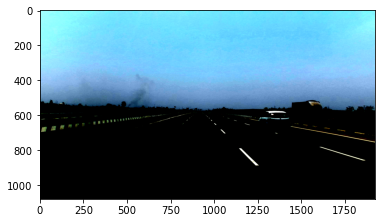

In [ ]:
#'rerun_baseline_'#'256x512nonrandomtransforms_model_4a_'
learning_rate,epochs = 0.005, 100
MODEL_NAME = 'resNet_model_best_model_' + str(learning_rate) + '_' + str(epochs)
test_dataset = IddDataset(csv_file='test.csv',resize=False)
fcn_model = torch.load(MODEL_NAME)
fcn_model.eval()
test_loader = DataLoader(dataset=test_dataset, batch_size= 1, num_workers=8, shuffle=False)
for itera, (X, tar, Y) in enumerate(test_loader):
    if use_gpu:
        inputs = X.cuda()# Move your inputs onto the gpu
        test_labels = Y.cuda()# Move your labels onto the gpu
    else:
        inputs, test_labels = X, Y#.long() # Unpack variables into inputs and labels
    outputs = fcn_model(inputs)
    predictions = torch.nn.functional.softmax(outputs,1)
    predictions = torch.argmax(predictions,dim=1)
    break
predictions = predictions.cpu().numpy()
inputImage = inputs[0].permute(1, 2, 0).cpu().numpy()
plt.imshow(inputImage)#, cmap='gray')
plt.show()
rows, cols = predictions.shape[1], predictions.shape[2]
#print(labels)
new_predictions = np.zeros((predictions.shape[1], predictions.shape[2], 3))
#unique_labels = set()
for row in range(rows):
    for col in range(cols):
        idx = int(predictions[0][row][col])
        #unique_labels.add(labels[idx].name)
        new_predictions[row][col][:] = np.asarray(labels[idx].color)/255
#print("Detected labels in the image: ",unique_labels)
plt.imshow(inputImage)#, cmap='gray')
plt.imshow(new_predictions,alpha=0.5)#, cmap='jet', alpha=0.5)
plt.axis('off')
fig_name = MODEL_NAME+"Overlayed_rerunfornewimage_noresize.jpg"
plt.savefig(fig_name)
plt.show()